# Notebook
## Sistem Rekomendasi Obat berdasarkan _Weighted Hybrid Approach_

Notebook ini menyajikan penerapan dan eksperimentasi _weighted hybrid approach_ pada sistem rekomendasi obat. _Weighted hybrid approach_ yang diusulkan merupakan kombinasi antara .... dan .... . Beberapa teknik pembobotan yang akan dimasukkan dalam eksperimentasi antara lain ...., ...., dan .....

## 1. Pustaka

Impor pustaka yang dibutuhkan.

In [1]:
# pustaka eksternal
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.spatial.distance import pdist, squareform
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# pustaka custom
from analysis import *

## 2. Persiapan Set Data

Pada bagian ini, dilakukan persiapan set data yang dibutuhkan dalam penelitian. Karena set data yang sesuai untuk secara langsung digunakan dalam penelitian ini belum tersedia saat penelitian ini dikerjakan, maka Peneliti melakukan pengumpulan data dari beberapa sumber dan menggabungkannya.

Set data `WebMD` dan `DailyMed` digabungkan dalam struktur data DataFrame.

In [2]:
# berkas WebMD Drug Reviews oleh Rohan Harode dari Kaggle
path_wmd = "data/webmd/webmd.csv"

# berkas DailyMed Drug dari situs web DailyMed
# yang dikompilasi dengan menggunakan generate_dailymed.py
path_dm = "data/dailymed/dailymed.csv"

df_wmd = pd.read_csv(path_wmd)
df_dm = pd.read_csv(path_dm)

Atribut yang diperlukan sebagai pelengkap data pada DailyMed, antara lain:
1. nama obat secara umum pada kolom `sub_name`
2. daftar bahan aktif pada kolom `list_activeIngredient`, dan 
3. daftar bahan inaktif pada kolom `list_activeIngredient`.

Oleh karena itu, perlu dilakukan seleksi kolom pada DataFrame `df_dm` sebagai berikut.

In [3]:
df_dm = df_dm[["SubName", "ListActiveIngredient", "ListInactiveIngredient"]]

Gabungkan DataFrame DailyMed `df_dm` dan DataFrame MebMD `df_wmd` dengan menggunakan kolom `sub_name` di `df_dm` dan kolom `Drug` di `df_wmd` sebagai indeks pengabungan.

In [4]:
df_drugs = pd.merge(df_dm, df_wmd, left_on = "SubName", right_on = "Drug")

## 3. Analisis Data

Dalam penelitian ini, analisis dilakukan pada `df_drugs` untuk memahami tipe data dan mengidentifikasi kesalahan. Informasi tersebut digunakan untuk menentukan prosedur yang sesuai dalam tahap prapemrosesan.

Kita mulai dengan menghitung jumlah masing-masing nilai yang berbeda pada kolom `Drug` untuk mengetahui jumlah baris data untuk setiap obat. Informasi ini diperlukan untuk memastikan kecukupan data penelitian.

In [5]:
display(df_drugs["Drug"].value_counts())

lisinopril             12807
simvastatin             7203
benzonatate             5999
meloxicam               5394
prednisone              5152
                       ...  
zolmitriptan               5
sevelamer carbonate        3
cromolyn sodium            2
caffeine citrate           2
bexarotene                 2
Name: Drug, Length: 74, dtype: int64

Pada sel tersebut, kita dapat melihat bahwa ada 74 nama obat dalam `df_drugs`. Obat dengan baris data terbanyak adalah `lisinopril` (12.807), sementara obat dengan baris data tersedikit adalah `cromolyn sodium`, `caffeine citrate`, dan `bexarotene` (2).

Jika menggunakan 500 baris data sebagai ambang batas kecukupan data, maka persentase jumlah obat disajikan sebagai berikut.

### Tipe data

In [6]:
df_drugs.dtypes

SubName                   object
ListActiveIngredient      object
ListInactiveIngredient    object
Age                       object
Condition                 object
Date                      object
Drug                      object
DrugId                     int64
EaseofUse                  int64
Effectiveness              int64
Reviews                   object
Satisfaction               int64
Sex                       object
Sides                     object
UsefulCount                int64
dtype: object

Untuk memeriksa tipe data dari masing2 varibael/kolom/fitur dengan menggunakan `.dtypes`. untuk dtype (object) pada pandas digunakan untuk tipe data Teks atau campuran nilai numerik dan non-numeric. untuk dtype (int64) pada pandas digunakan untuk tipe data Integer numbers. Pada sel diatas, kita dapat melihat bahwa 2 jenis type data yang muncul yaitu object dan int64.

In [7]:
for col in df_drugs:
    drugs = pd.get_dummies(df_drugs[col],prefix='', prefix_sep='').sum() 
    print(col, ":", drugs)

SubName : acarbose           24
acetazolamide     285
aripiprazole      477
baclofen          550
benzonatate      5999
                 ... 
valproic acid     124
voriconazole       33
zaleplon           82
zolmitriptan        5
zonisamide        202
Length: 74, dtype: int64
ListActiveIngredient : [['ACARBOSE', '25', 'mg', '1', '1']]           24
[['ACETAZOLAMIDE', '125', 'mg', '1', '1']]     95
[['ACETAZOLAMIDE', '250', 'mg', '1', '1']]     95
[['ACETAZOLAMIDE', '500', 'mg', '1', '1']]     95
[['ARIPIPRAZOLE', '1', 'mg', '1', 'mL']]       53
                                             ... 
[['linezolid', '2', 'mg', '1', 'mL']]           4
[['lovastatin', '10', 'mg', '1', '1']]        168
[['metolazone', '2.5', 'mg', '1', '1']]        27
[['ofloxacin', '3', 'mg', '1', 'mL']]           9
[['valproic acid', '250', 'mg', '1', '1']]     62
Length: 137, dtype: int64
ListInactiveIngredient : [['ACETIC ACID', '', '', '', ''], ['SODIUM CHLORIDE', '', '', '', ''], ['SODIUM ACETATE', '', '', '

Date : 1/1/2008    29
1/1/2009    34
1/1/2010    26
1/1/2011    18
1/1/2012    10
            ..
9/9/2013    16
9/9/2014     5
9/9/2015    20
9/9/2016    10
9/9/2017     5
Length: 3884, dtype: int64
Drug : acarbose           24
acetazolamide     285
aripiprazole      477
baclofen          550
benzonatate      5999
                 ... 
valproic acid     124
voriconazole       33
zaleplon           82
zolmitriptan        5
zonisamide        202
Length: 74, dtype: int64
DrugId : 676         96
911       5394
1027       114
1049       265
1636       352
          ... 
64437      477
93290      324
94574       23
148989     140
149812       3
Length: 74, dtype: int64
EaseofUse : 1     6681
2     3137
3     7106
4    12583
5    32162
dtype: int64
Effectiveness : 1    12037
2     6225
3    11020
4    13830
5    18557
dtype: int64
Reviews : \n                                                                                                                                                        

Pada sel diatas, kita dapat melihat rentang nilai dari setiap atribut. 

|     Nama attribut      |      Tipe Attribut     |                Rentang Nilai                                    |
| ---------------------- | -----------------------| ----------------------------------------------------------------|
|      SubName           |        Nominal         |  acarbose, acetazolamide , aripiprazole, baclofen, benzonatate,...,valproic acid, voriconazole, zaleplon, zolmitriptan, zolmitriptan, zonisamide   |
| ListActiveIngredient   |        Nominal         |  ACARBOSE 25 mg -1-1, ACETAZOLAMIDE 125 mg -1-1, ACETAZOLAMIDE 250 mg -1-1, ACETAZOLAMIDE 500 mg -1-1, ARIPIPRAZOLE1 mg 1mL, ...,valproic acid 250 mg -1-1 |
| ListInactiveIngredient |        Nominal         |  ACETIC ACID, SODIUM CHLORIDE, SODIUM ACETATE, WATER, ALCOHOL, ANHYDROUS CITRIC ACID, ... sodium hydroxide, hydrochloric acid|
|       Age              |        Nominal         |  0-2, 13-18, 19-24, 25-34, 3-6, 35-44, 45-54, 55-64, 65-74, 7-12, 75 or over|
|     Condition          |        Nominal         |  "Change of Life" Signs, A Condition of Bladder Dysfunction from Nerve Disorder , A Condition of Bladder Dysfunction from Nerve Disorder, ..., infection caused by bacteria    |
|     Date               |        Nominal         | 1/1/2008, 1/1/2009, 1/1/2011, 1/1/2012, ..., 9/9/2013 9/9/2017         |
|     Drug               |        Nominal         | acarbose, acetazolamide, aripiprazole, baclofen, benzonatate, ... zonisamide |
|     DrugId             |        Nominal         | 676, 911, 1027, 1049, 1636, ... ,93290,  94574, 148989,  149812  |
|     EaseofUse          |       Ordinal          |  1, 2, 3, 4, 5                                                   |
|     Effectiveness      |       Ordinal          |  1, 2, 3, 4, 5                                                   |
|    Reviews             |       Nominal          |  an this drug be taken on a long term bases? I had a cough for years that I dr with and nothing worked. I was told it can not be taken long term. What is the side effects if taken long term, ......   a 90 day supply of Lisinopril 10 mg which averages $3.33 per month. |
|     Satisfaction       |       Ordinal          |  1, 2, 3, 4, 5                                                   |
|     Sex                |       Binary           |  Female, Male                                                    |
|     Sides              |       Nominal          |  Constipation ,  nausea ,  headache ,  diarrhea ,  vomiting ,  stomach  upset, gas, tremor,  dizziness , drowsiness, or  trouble sleeping  may occur, ... Upset stomach ,  nausea ,  vomiting , gas, or  diarrhea  may occur |
|     UsefulCount        |       Ordinal          |  0, 1, 2, 3, 4...... 140                                          |


### Mengidentifikasi Kesalahan

In [8]:
df_drugs.isnull().sum()

SubName                    0
ListActiveIngredient       0
ListInactiveIngredient     0
Age                        0
Condition                  0
Date                       0
Drug                       0
DrugId                     0
EaseofUse                  0
Effectiveness              0
Reviews                   16
Satisfaction               0
Sex                        0
Sides                      0
UsefulCount                0
dtype: int64

Dalam mengidentifikasi kesalahahan dapat dilakukan agregasi data menggunakan fungsi sum(). Berdasarkan analisis diatas dapat dilihat bahwa dalam dataset tersebut hanya ada satu atribut yang memiliki nilai kosong atau NULL sebanyak 16 missing value.

In [9]:
s = pd.get_dummies(df_drugs['SubName'],prefix='', prefix_sep='').sum() 
item_counts = df_drugs["SubName"].value_counts()
for i in item_counts.items():
    print(i) 

('lisinopril', 12807)
('simvastatin', 7203)
('benzonatate', 5999)
('meloxicam', 5394)
('prednisone', 5152)
('topiramate', 2844)
('spironolactone', 2660)
('metronidazole', 1911)
('hydrochlorothiazide', 1710)
('diclofenac sodium', 1192)
('methylprednisolone', 1174)
('pravastatin sodium', 1072)
('risperidone', 985)
('fluconazole', 912)
('lithium carbonate', 874)
('ibuprofen', 813)
('temazepam', 784)
('cephalexin', 696)
('isosorbide mononitrate', 553)
('baclofen', 550)
('aripiprazole', 477)
('clarithromycin', 448)
('lamotrigine', 363)
('medroxyprogesterone acetate', 352)
('dextroamphetamine sulfate', 352)
('fenofibrate', 324)
('indomethacin', 315)
('acetazolamide', 285)
('fluvoxamine maleate', 265)
('furosemide', 225)
('zonisamide', 202)
('cilostazol', 200)
('lovastatin', 168)
('erythromycin', 146)
('levocetirizine dihydrochloride', 140)
('valproic acid', 124)
('ketoconazole', 120)
('levetiracetam', 117)
('dexamethasone', 114)
('rifampin', 106)
('pyridostigmine bromide', 102)
('montelukast

Untuk kolom atribut sub_name tidak ada nilai aneh atau ganjil serta tidak ditemukan nilai yang kosong pada field sub_name 

In [10]:
s = pd.get_dummies(df_drugs['ListActiveIngredient'],prefix='', prefix_sep='').sum() 
item_counts = df_drugs["ListActiveIngredient"].value_counts()
for i in item_counts.items():
    print(i) 

("[['MELOXICAM', '7.5', 'mg', '1', '1']]", 4495)
("[['LISINOPRIL ANHYDROUS', '2.5', 'mg', '1', '1']]", 4269)
("[['LISINOPRIL ANHYDROUS', '20', 'mg', '1', '1']]", 4269)
("[['LISINOPRIL ANHYDROUS', '5', 'mg', '1', '1']]", 4269)
("[['BENZONATATE', '100', 'mg', '1', '1']]", 3428)
("[['PREDNISONE', '10', 'mg', '1', '1']]", 2576)
("[['PREDNISONE', '1', 'mg', '1', '1']]", 2576)
("[['SIMVASTATIN', '10', 'mg', '1', '1']]", 2058)
("[['SIMVASTATIN', '40', 'mg', '1', '1']]", 2058)
("[['SIMVASTATIN', '5', 'mg', '1', '1']]", 2058)
("[['HYDROCHLOROTHIAZIDE', '12.5', 'mg', '1', '1']]", 1710)
("[['DICLOFENAC', '30', 'mg', '1', 'g']]", 1192)
("[['TOPIRAMATE', '25', 'mg', '1', '1']]", 1185)
("[['SPIRONOLACTONE', '25', 'mg', '1', '1']]", 1140)
("[['SIMVASTATIN', '20', 'mg', '1', '1']]", 1029)
("[['MELOXICAM', '15', 'mg', '1', '1']]", 899)
("[['LITHIUM CATION', '300', 'mg', '1', '1']]", 874)
("[['BENZONATATE', '150', 'mg', '1', '1']]", 857)
("[['benzonatate', '100', 'mg', '1', '1']]", 857)
("[['BENZONATATE

Untuk kolom atribut list_activeIngredient tidak ada nilai aneh atau ganjil serta tidak ditemukan nilai yang kosong pada field list_activeIngredient

In [11]:
s = pd.get_dummies(df_drugs['ListInactiveIngredient'],prefix='', prefix_sep='').sum() 
item_counts = df_drugs["ListInactiveIngredient"].value_counts()
for i in item_counts.items():
    print(i) 

("[['CELLULOSE, MICROCRYSTALLINE', '', '', '', ''], ['HYDROXYPROPYL CELLULOSE (110000 WAMW)', '', '', '', ''], ['HYPROMELLOSE 2910 (5 MPA.S)', '', '', '', ''], ['CROSCARMELLOSE SODIUM', '', '', '', ''], ['FERRIC OXIDE RED', '', '', '', ''], ['LACTOSE MONOHYDRATE', '', '', '', ''], ['MAGNESIUM STEARATE', '', '', '', ''], ['TALC', '', '', '', ''], ['STARCH, CORN', '', '', '', ''], ['BUTYLATED HYDROXYANISOLE', '', '', '', ''], ['TITANIUM DIOXIDE', '', '', '', ''], ['ASCORBIC ACID', '', '', '', ''], ['CITRIC ACID MONOHYDRATE', '', '', '', ''], ['TRIETHYL CITRATE', '', '', '', '']]", 5145)
("[['D&C YELLOW NO. 10', '', '', '', ''], ['GELATIN', '', '', '', ''], ['GLYCERIN', '', '', '', ''], ['WATER', '', '', '', ''], ['METHYLPARABEN', '', '', '', ''], ['PROPYLPARABEN', '', '', '', ''], ['TITANIUM DIOXIDE', '', '', '', '']]", 4285)
("[['ANHYDROUS DIBASIC CALCIUM PHOSPHATE', '', '', '', ''], ['MAGNESIUM STEARATE', '', '', '', ''], ['MANNITOL', '', '', '', ''], ['STARCH, CORN', '', '', '', '']]"

Untuk kolom atribut ListInactiveIngredient tidak ada nilai aneh atau ganjil serta tidak ditemukan nilai yang kosong pada field ListInactiveIngredient

In [12]:
s = pd.get_dummies(df_drugs['Age'],prefix='', prefix_sep='').sum() 
item_counts = df_drugs["Age"].value_counts()
for i in item_counts.items():
    print(i) 

('55-64', 15621)
('45-54', 14618)
('65-74', 9028)
('35-44', 8011)
('25-34', 5712)
('75 or over', 3615)
('19-24', 2295)
(' ', 1941)
('13-18', 566)
('7-12', 178)
('3-6', 48)
('0-2', 36)


Untuk kolom atribut 'Age' terdapat nilai kosong atau missing value sebanyak 1941 

In [13]:
s = pd.get_dummies(df_drugs['Condition'],prefix='', prefix_sep='').sum() 
item_counts = df_drugs["Condition"].value_counts()
for i in item_counts.items():
    print(i) 

('High Blood Pressure', 13542)
('Other', 7499)
('Cough', 5894)
('High Cholesterol', 4909)
('Joint Damage causing Pain and Loss of Function', 3064)
('Migraine Prevention', 1788)
('Combined High Blood Cholesterol and Triglyceride Level', 1648)
('Rheumatoid Arthritis', 1548)
('Vaginosis caused by Bacteria', 921)
('Asthma', 822)
('Bipolar Depression', 814)
('Chronic Trouble Sleeping', 762)
('Increased Triglycerides and Cholesterol', 507)
('Visible Water Retention', 490)
('Yeast Infection of Vagina and Vulva', 460)
('Homozygous Inherited High Blood Cholesterol', 420)
('Pain', 392)
('Treatment to Prevent a Heart Attack', 384)
('Arthritis', 382)
('Additional Medications to Treat Depression', 361)
('Rheumatic Disease causing Pain & Stiffness in Backbone', 348)
('High Amount of Triglyceride in the Blood', 335)
('Kidney Disease from Diabetes', 310)
('Diverticulitis', 303)
('Angina Pectoris Prevention', 288)
('Heart Attack', 269)
('Muscle Pain and Stiffness in Shoulder, Neck and Pelvis', 259)
('S

Untuk kolom atribut Condition tidak ada nilai aneh atau ganjil serta tidak ditemukan nilai yang kosong pada field 'Condition'

In [14]:
s = pd.get_dummies(df_drugs['Date'],prefix='', prefix_sep='').sum() 
item_counts = df_drugs["Date"].value_counts()
for i in item_counts.items():
    print(i) 

('3/16/2010', 88)
('10/29/2009', 80)
('6/1/2009', 78)
('2/24/2009', 72)
('1/5/2009', 71)
('5/22/2009', 70)
('1/27/2011', 69)
('8/13/2009', 68)
('2/28/2010', 67)
('5/26/2009', 67)
('4/19/2009', 66)
('1/4/2010', 65)
('6/26/2009', 63)
('7/29/2009', 63)
('7/21/2009', 62)
('6/2/2009', 62)
('1/24/2010', 62)
('7/15/2009', 61)
('5/5/2009', 60)
('4/30/2009', 60)
('7/15/2010', 60)
('6/17/2009', 59)
('3/10/2009', 59)
('1/29/2008', 56)
('2/16/2009', 56)
('5/18/2009', 55)
('1/5/2010', 55)
('12/2/2008', 55)
('4/10/2008', 55)
('1/7/2009', 55)
('1/13/2009', 55)
('3/18/2009', 55)
('10/18/2011', 54)
('8/30/2009', 54)
('11/14/2009', 53)
('2/27/2009', 53)
('9/15/2010', 53)
('1/8/2010', 52)
('9/27/2008', 52)
('10/27/2009', 52)
('11/9/2009', 52)
('1/14/2009', 52)
('1/3/2008', 52)
('7/8/2009', 51)
('11/5/2009', 51)
('6/5/2009', 51)
('7/28/2009', 51)
('10/15/2009', 51)
('2/28/2009', 51)
('10/23/2009', 51)
('9/17/2009', 50)
('7/1/2009', 50)
('5/4/2009', 50)
('2/5/2008', 50)
('1/18/2009', 50)
('2/4/2010', 50)
(

Untuk kolom atribut 'Date' tidak ada nilai aneh atau ganjil serta tidak ditemukan nilai yang kosong pada field 'Date'

In [15]:
s = pd.get_dummies(df_drugs['Drug'],prefix='', prefix_sep='').sum() 
item_counts = df_drugs["Drug"].value_counts()
for i in item_counts.items():
    print(i) 

('lisinopril', 12807)
('simvastatin', 7203)
('benzonatate', 5999)
('meloxicam', 5394)
('prednisone', 5152)
('topiramate', 2844)
('spironolactone', 2660)
('metronidazole', 1911)
('hydrochlorothiazide', 1710)
('diclofenac sodium', 1192)
('methylprednisolone', 1174)
('pravastatin sodium', 1072)
('risperidone', 985)
('fluconazole', 912)
('lithium carbonate', 874)
('ibuprofen', 813)
('temazepam', 784)
('cephalexin', 696)
('isosorbide mononitrate', 553)
('baclofen', 550)
('aripiprazole', 477)
('clarithromycin', 448)
('lamotrigine', 363)
('medroxyprogesterone acetate', 352)
('dextroamphetamine sulfate', 352)
('fenofibrate', 324)
('indomethacin', 315)
('acetazolamide', 285)
('fluvoxamine maleate', 265)
('furosemide', 225)
('zonisamide', 202)
('cilostazol', 200)
('lovastatin', 168)
('erythromycin', 146)
('levocetirizine dihydrochloride', 140)
('valproic acid', 124)
('ketoconazole', 120)
('levetiracetam', 117)
('dexamethasone', 114)
('rifampin', 106)
('pyridostigmine bromide', 102)
('montelukast

Untuk kolom atribut 'Drug' tidak ada nilai aneh atau ganjil serta tidak ditemukan nilai yang kosong pada field 'Drug'

In [16]:
s = pd.get_dummies(df_drugs['EaseofUse'],prefix='', prefix_sep='').sum() 
item_counts = df_drugs["EaseofUse"].value_counts()
for i in item_counts.items():
    print(i) 

(5, 32162)
(4, 12583)
(3, 7106)
(1, 6681)
(2, 3137)


Untuk kolom atribut 'EaseofUse' tidak ada nilai aneh atau ganjil serta tidak ditemukan nilai yang kosong pada field 'EaseofUse'

In [17]:
s = pd.get_dummies(df_drugs['Effectiveness'],prefix='', prefix_sep='').sum() 
item_counts = df_drugs["Effectiveness"].value_counts()
for i in item_counts.items():
    print(i) 

(5, 18557)
(4, 13830)
(1, 12037)
(3, 11020)
(2, 6225)


Untuk kolom atribut 'Effectiveness' tidak ada nilai aneh atau ganjil serta tidak ditemukan nilai yang kosong pada field 'Effectiveness'

In [18]:
s = pd.get_dummies(df_drugs['Satisfaction'],prefix='', prefix_sep='').sum() 
item_counts = df_drugs["Satisfaction"].value_counts()
for i in item_counts.items():
    print(i) 

(1, 21189)
(5, 15222)
(4, 9397)
(3, 8930)
(2, 6931)


Untuk kolom atribut 'Satisfaction' tidak ada nilai aneh atau ganjil serta tidak ditemukan nilai yang kosong pada field 'Satisfaction'

In [19]:
s = pd.get_dummies(df_drugs['Sex'],prefix='', prefix_sep='').sum() 
item_counts = df_drugs["Sex"].value_counts()
for i in item_counts.items():
    print(i) 

('Female', 38854)
('Male', 18466)
(' ', 4349)


Untuk kolom atribut 'Sex' terdapat nilai kosong atau missing value sebanyak 4349

In [20]:
s = pd.get_dummies(df_drugs['Sides'],prefix='', prefix_sep='').sum() 
item_counts = df_drugs["Sides"].value_counts()
for i in item_counts.items():
    print(i)

('Dizziness ,  lightheadedness , tiredness, or  headache  may occur as your body adjusts to the  medication . Dry  cough  may also occur.', 12807)
(' ', 8868)
('Drowsiness,  dizziness ,  headache ,  nausea ,  stomach  upset,  constipation , and stuffy nose may occur.', 5999)
('Stomach  upset,  nausea ,  dizziness , or  diarrhea  may occur.', 5394)
('Nausea ,  vomiting , loss of appetite,  heartburn ,  trouble sleeping , increased  sweating , or  acne  may occur.', 5152)
('Tiredness, drowsiness,  dizziness , loss of coordination, tingling of the hands/feet, loss of appetite, bad taste in your  mouth ,  diarrhea , and  weight loss  may occur.', 2844)
('Drowsiness,  dizziness ,  lightheadedness ,  stomach  upset,  diarrhea ,  nausea ,  vomiting , or  headache  may occur.', 2660)
('Dizziness ,  headache ,  stomach  upset,  nausea ,  vomiting , loss of appetite,  diarrhea ,  constipation , or  metallic taste  in your  mouth  may occur.', 1911)
('Upset stomach ,  dizziness , or  headache  ma

Untuk kolom atribut 'Sides' tidak ada nilai aneh atau ganjil serta tidak ditemukan nilai yang kosong pada field 'Sides'

In [21]:
s = pd.get_dummies(df_drugs['UsefulCount'],prefix='', prefix_sep='').sum() 
item_counts = df_drugs["UsefulCount"].value_counts()
for i in item_counts.items():
    print(i)

(0, 11214)
(1, 7700)
(2, 6022)
(3, 4601)
(4, 3478)
(5, 3149)
(6, 2557)
(7, 2354)
(8, 2131)
(9, 1763)
(11, 1589)
(10, 1576)
(12, 1479)
(13, 1114)
(14, 1097)
(15, 1032)
(16, 949)
(18, 801)
(17, 720)
(19, 604)
(20, 592)
(21, 582)
(22, 449)
(24, 370)
(25, 350)
(23, 334)
(28, 282)
(27, 277)
(26, 210)
(31, 205)
(29, 202)
(30, 198)
(32, 154)
(34, 134)
(33, 120)
(35, 108)
(40, 94)
(37, 94)
(42, 88)
(36, 77)
(39, 68)
(41, 65)
(38, 63)
(43, 60)
(47, 59)
(45, 41)
(48, 31)
(46, 30)
(44, 28)
(52, 25)
(54, 23)
(51, 23)
(59, 18)
(50, 18)
(63, 17)
(53, 17)
(57, 17)
(61, 16)
(62, 15)
(49, 13)
(66, 12)
(78, 11)
(70, 10)
(56, 10)
(60, 9)
(71, 9)
(55, 8)
(88, 7)
(107, 7)
(79, 7)
(65, 7)
(64, 6)
(109, 6)
(58, 6)
(67, 5)
(84, 4)
(77, 4)
(68, 4)
(81, 4)
(74, 4)
(83, 3)
(140, 3)
(112, 3)
(113, 3)
(100, 3)
(72, 2)
(69, 2)
(96, 2)
(127, 2)
(101, 2)
(89, 2)
(82, 2)
(80, 2)
(91, 1)


Untuk kolom atribut 'UsefulCount' tidak ada nilai aneh atau ganjil serta tidak ditemukan nilai yang kosong pada field 'UsefulCount'

In [22]:
data1 = df_drugs.drop(columns = ['Reviews'])
for col in data1:
    s = pd.get_dummies(df_drugs[col],prefix='', prefix_sep='').sum() 
    print(col, ":", s)

# s = pd.get_dummies(data1,prefix='', prefix_sep='').sum().sort()
# s

SubName : acarbose           24
acetazolamide     285
aripiprazole      477
baclofen          550
benzonatate      5999
                 ... 
valproic acid     124
voriconazole       33
zaleplon           82
zolmitriptan        5
zonisamide        202
Length: 74, dtype: int64
ListActiveIngredient : [['ACARBOSE', '25', 'mg', '1', '1']]           24
[['ACETAZOLAMIDE', '125', 'mg', '1', '1']]     95
[['ACETAZOLAMIDE', '250', 'mg', '1', '1']]     95
[['ACETAZOLAMIDE', '500', 'mg', '1', '1']]     95
[['ARIPIPRAZOLE', '1', 'mg', '1', 'mL']]       53
                                             ... 
[['linezolid', '2', 'mg', '1', 'mL']]           4
[['lovastatin', '10', 'mg', '1', '1']]        168
[['metolazone', '2.5', 'mg', '1', '1']]        27
[['ofloxacin', '3', 'mg', '1', 'mL']]           9
[['valproic acid', '250', 'mg', '1', '1']]     62
Length: 137, dtype: int64
ListInactiveIngredient : [['ACETIC ACID', '', '', '', ''], ['SODIUM CHLORIDE', '', '', '', ''], ['SODIUM ACETATE', '', '', '

Condition :                                                            11
"Change of Life" Signs                                     17
A Condition of Bladder Dysfunction from Nerve Disorder      2
A Fungal Infection - Aspergillosis                          6
A Hereditary Progressive Anemia of Unknown Cause           18
                                                         ... 
Wide-Angle Glaucoma                                         2
Worsening of Asthma                                        66
Yeast Infection of Vagina and Vulva                       460
infection                                                   3
infection caused by bacteria                               19
Length: 405, dtype: int64
Date : 1/1/2008    29
1/1/2009    34
1/1/2010    26
1/1/2011    18
1/1/2012    10
            ..
9/9/2013    16
9/9/2014     5
9/9/2015    20
9/9/2016    10
9/9/2017     5
Length: 3884, dtype: int64
Drug : acarbose           24
acetazolamide     285
aripiprazole      477
baclofen

In [23]:
n_sufficient = sum(x >= 500 for x in df_drugs["Drug"].value_counts())
n_insufficient = sum(x < 500 for x in df_drugs["Drug"].value_counts())
print("Cukup", n_sufficient, "dan", "Tidak Cukup:", n_insufficient)
# fig = go.Figure(data=[go.Pie(labels=["Cukup", "Tidak Cukup"],
#                              values=[n_sufficient, n_insufficient], hole = 0.5)])
# fig.show()

Cukup 20 dan Tidak Cukup: 54


Memperhatikan persentase tersebut, maka diperlukan penambahan lebih banyak baris data untuk setiap obat dengan total baris data yang kurang dari 500. Untuk saat ini, kita cukup gunakan baris data obat yang cukup.

In [24]:
list_sufficient = [val for val, cnt in df_drugs["Drug"].value_counts().iteritems() if cnt >= 500]
df_drugs_sub = df_drugs[df_drugs["Drug"].isin(list_sufficient)]
df_drugs_sub[(df_drugs_sub["Age"] == " ") & (df_drugs_sub["Sex"] == " ")].head()

,SubName,ListActiveIngredient,ListInactiveIngredient,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
426,cephalexin,"[['CEPHALEXIN', '250', 'mg', '1', '1']]","[['MAGNESIUM STEARATE', '', '', '', ''], ['D&C...",,Bacterial Urinary Tract Infection,8/12/2013,cephalexin,11757,3,4,Got this med in the ER prescribed for urinary ...,1,,"Diarrhea , nausea , vomiting , or upset sto...",0
489,cephalexin,"[['CEPHALEXIN', '250', 'mg', '1', '1']]","[['MAGNESIUM STEARATE', '', '', '', ''], ['D&C...",,Infection of the Middle Ear by H. Influenzae B...,5/21/2011,cephalexin,11757,5,1,ok,5,,"Diarrhea , nausea , vomiting , or upset sto...",0
511,cephalexin,"[['CEPHALEXIN', '250', 'mg', '1', '1']]","[['MAGNESIUM STEARATE', '', '', '', ''], ['D&C...",,Other,1/31/2008,cephalexin,11757,3,4,It has worked well in getting rid of the sinus...,2,,"Diarrhea , nausea , vomiting , or upset sto...",20
588,cephalexin,"[['CEPHALEXIN', '250', 'mg', '1', '1']]","[['MAGNESIUM STEARATE', '', '', '', ''], ['D&C...",,Skin Infection,9/29/2009,cephalexin,11757,5,4,Read some of the reviews before I started taki...,4,,"Diarrhea , nausea , vomiting , or upset sto...",3
660,cephalexin,"[['CEPHALEXIN', '250', 'mg', '1', '1']]","[['MAGNESIUM STEARATE', '', '', '', ''], ['D&C...",,Strep Throat and Tonsillitis,8/23/2008,cephalexin,11757,5,5,,5,,"Diarrhea , nausea , vomiting , or upset sto...",3


In [25]:
# df_drugs_sub.pivot_table(columns=["Sex", "Age", "Condition"], aggfunc="size")

Periksa banyaknya baris data dengan nilai atribut `Age` dan `Sex` yang kosong.

In [26]:
cnt_empty_agensex = df_drugs_sub[(df_drugs_sub["Age"] == " ") & (df_drugs_sub["Sex"] == " ")].shape[0]
print("Jumlah baris data dengan nilai atribut Age dan Sex yang kosong adalah", cnt_empty_agensex)

Jumlah baris data dengan nilai atribut Age dan Sex yang kosong adalah 1051


## 4. Prapemrosesan

...

Tahap pertama pemrosesan adalah mengubah nilai pada kolom `ListActiveIngredient` ke dalam bentuk _one-hot encoding vector_. _One-hot encoding_ mengubah fitur kategorikal/nominal ke format yang lebih sesuai digunakan dalam algoritma klasifikasi dan regresi. Dalam sistem rekomendasi ini, algoritma klasifikasi digunakan sebagai pembentuk model _hybrid_. 

In [27]:
def active_ingredient_text_cleaning(txt_in):
    txt_out = txt_in.replace("[[", "")
    txt_out = txt_out.replace("]]", "")
    list_out = txt_out.split("], [")
    list_out = [[j.strip("\'") for j in i.split(",")][0].lower() for i in list_out]
    return list_out

list_active_ingredients = []
for i in df_drugs_sub['ListActiveIngredient']:
    list_active_ingredients.append(active_ingredient_text_cleaning(i))

# hapus kolom list active ingredient
df_drugs_sub = df_drugs_sub.drop(columns = ["ListActiveIngredient"])
# buat kolom active ingredients berdasarkan list active ingredients
df_drugs_sub["ActiveIngredients"] = list_active_ingredients

# # one-hot encoding
# mlb = MultiLabelBinarizer()
# df_drugs_sub = df_drugs_sub.join(pd.DataFrame(mlb.fit_transform(df_drugs_sub.pop("ActiveIngredients")),
#                                               columns=mlb.classes_,
#                                               index=df_drugs_sub.index))

Tahap kedua pemrosesan adalah mengubah nilai pada kolom `ListInactiveIngredient` ke dalam bentuk _one-hot encoding vector_, sama seperti pada `ListActiveIngredient`. 

In [28]:
def inactive_ingredient_text_cleaning(txt_in):
    txt_out = txt_in.replace("[[", "")
    txt_out = txt_out.replace("]]", "")
    list_out = txt_out.split("], [")
    list_out = [[j.strip("\'") for j in i.split(",")][0].lower() for i in list_out]
    return list_out

list_inactive_ingredients = []
for i in df_drugs_sub['ListInactiveIngredient']:
    list_inactive_ingredients.append(inactive_ingredient_text_cleaning(i))

# hapus kolom list inactive ingredient
df_drugs_sub = df_drugs_sub.drop(columns = ["ListInactiveIngredient"])
# buat kolom inactive ingredients berdasarkan list inactive ingredients
df_drugs_sub["InactiveIngredients"] = list_inactive_ingredients

# # one-hot encoding
# mlb = MultiLabelBinarizer()
# df_drugs_sub = df_drugs_sub.join(pd.DataFrame(mlb.fit_transform(df_drugs_sub.pop("InactiveIngredients")),
#                                               columns=mlb.classes_,
#                                               index=df_drugs_sub.index))

Tahap ketiga pemrosesan adalah mengubah nilai pada kolom `sides` ke dalam bentuk _one-hot encoding vector_, sama seperti pada `ListActiveIngredient` dan `ListInactiveIngredient`. 

In [29]:
def sides_text_cleaning(txt_in):
    # ganti whitespace lebih dari 1 menjadi 1 
    txt_out = re.sub('\s+', ' ', txt_in)
    # hapus kalimat keterangan
    txt_out = txt_out.replace("If any of these effects persist or worsen, tell your doctor or pharmacist promptly.", "")
    txt_out = txt_out.replace("If any of these effects last or get worse, tell your doctor or pharmacist promptly.", "")
    txt_out = txt_out.replace("may occur, especially during the first 2 hours after you take the medication .", "")
    txt_out = txt_out.replace("may occur as your body adjusts to this medication .", "")
    txt_out = txt_out.replace("may occur as your body adjusts to the medication .", "")
    txt_out = txt_out.replace("may also occur.", "")
    txt_out = txt_out.replace("may occur.", "")
    txt_out = txt_out.replace("and ", "")
    txt_out = txt_out.replace("your ", "")
    txt_out = txt_out.replace("or ", "")
    return txt_out

list_sides = []
for id, val in df_drugs_sub["Sides"].iteritems():
    # pembersihan text sides dan tokenisasi text sides
    list_sides.append([i.strip().lower() for i in sides_text_cleaning(val).split(",")])

# hapus kolom sides yang lama
df_drugs_sub = df_drugs_sub.drop(columns = ["Sides"])
# buat kolom sides yang baru berdasarkan list sides
df_drugs_sub["Sides"] = list_sides

# # one-hot encoding
# mlb = MultiLabelBinarizer()
# df_drugs_sub = df_drugs_sub.join(pd.DataFrame(mlb.fit_transform(df_drugs_sub.pop("Sides")),
#                                               columns=mlb.classes_,
#                                               index=df_drugs_sub.index))

Pada `df_drugs` terdapat 1.051 baris data dengan nilai atribut `Age` dan `Sex` yang kosong. Oleh karena itu, dilakukan imputasi dengan menggunakan Simple Imputer.

In [30]:
# label encoding map untuk nilai pada sex
map_sex = {"Male":0, "Female":1}
# label encoding map untuk nilai pada age
map_age = {'0-2':0,
           '3-6':1,
           '7-12':2,
           '13-18':3,
           '19-24':4,
           '25-34':5,
           '35-44':6,
           '45-54':7,
           '55-64':8,
           '65-74':9,
           '75 or over':10}

df_tmp = df_drugs_sub.copy()
# label encoding pada sex
df_tmp["Sexmap"] = df_tmp["Sex"].map(map_sex)
# label encoding pada age
df_tmp["Agemap"] = df_tmp["Age"].map(map_age)

# inverted label encoding map untuk nilai pada sex
inv_map_sex = {v: k for k, v in map_sex.items()}
# inverted label encoding map untuk nilai pada age
inv_map_age = {v: k for k, v in map_age.items()}

# penanganan missing values pada sex dan age
# imp = KNNImputer(n_neighbors=1)
imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
mat = imp.fit_transform(df_tmp[["Agemap", "Sexmap", "Satisfaction"]])
df_tmp2 = pd.DataFrame(mat, columns=["NewAge", "NewSex", "NewSatisfaction"])
df_drugs_sub["Sex"] = df_tmp2["NewSex"].map(inv_map_sex).tolist()
df_drugs_sub["Age"] = df_tmp2["NewAge"].map(inv_map_age).tolist()

# reset index setiap baris
df_drugs_sub = df_drugs_sub.reset_index(drop=True)

### Pembagian set data

Untuk menerapkan _item-based collaborative filtering_ pada sistem rekomendasi obat, dibutuhkan matriks pengguna/obat. Pada matriks tersebut terdapat _"user id"_, _"drug id"_, dan _"drug rating"_. Ilustrasi matriks tersebut adalah sebagai berikut.

|  | drug<sub>1</sub> | drug<sub>2</sub> | drug<sub>3</sub> |
| :---: | :---: | :---: | :---: |
| user<sub>1</sub> | rating<sub>user<sub>1</sub>,drug<sub>1</sub></sub> | rating<sub>user<sub>1</sub>,drug<sub>2</sub></sub> | rating<sub>user<sub>1</sub>,drug<sub>3</sub></sub> |
| user<sub>2</sub> | rating<sub>user<sub>2</sub>,drug<sub>1</sub></sub> | rating<sub>user<sub>2</sub>,drug<sub>2</sub></sub> | rating<sub>user<sub>2</sub>,drug<sub>3</sub></sub> |
| user<sub>3</sub> | rating<sub>user<sub>3</sub>,drug<sub>1</sub></sub> | rating<sub>user<sub>3</sub>,drug<sub>2</sub></sub> | rating<sub>user<sub>3</sub>,drug<sub>3</sub></sub> |
| user<sub>4</sub> | rating<sub>user<sub>4</sub>,drug<sub>1</sub></sub> | rating<sub>user<sub>4</sub>,drug<sub>2</sub></sub> | rating<sub>user<sub>4</sub>,drug<sub>3</sub></sub> |
| user<sub>5</sub> | rating<sub>user<sub>5</sub>,drug<sub>1</sub></sub> | rating<sub>user<sub>5</sub>,drug<sub>2</sub></sub> | rating<sub>user<sub>5</sub>,drug<sub>3</sub></sub> |


_"user id"_ tidak tersedia dalam `df_drugs`. Oleh karena itu, ....

_"drug id"_ tersedia dalam `df_drugs`. Oleh karena itu, ....

_"drug rating"_ tidak tersedia dalam `df_drugs`. Oleh karena itu, ....

In [31]:
# Data Drug
df_item = pd.DataFrame({'Drug':df_drugs_sub['Drug'],
                        'ActiveIngredients':df_drugs_sub['ActiveIngredients'],
                        'InactiveIngredients':df_drugs_sub['InactiveIngredients'],
                        'Sides':df_drugs_sub['Sides']})

# buat duplikat df_item, yaitu df_tmp
df_tmp = df_item.copy()
# ubah nilai ActiveIngredients dari list of string menjadi
# string untuk memungkinkan fungsi drop_duplicates dijalankan
df_tmp['ActiveIngredients'] = [" ".join(i) for i in df_tmp['ActiveIngredients']]
# ubah nilai InactiveIngredients dari list of string menjadi
# string untuk memungkinkan fungsi drop_duplicates dijalankan
df_tmp['InactiveIngredients'] = [" ".join(i) for i in df_tmp['InactiveIngredients']]
# ubah nilai Sides dari list of string menjadi
# string untuk memungkinkan fungsi drop_duplicates dijalankan
df_tmp['Sides'] = [" ".join(i) for i in df_tmp['Sides']]
# hapus baris data duplikat pada df_tmp dan simpan index
# baris data yang dipertahankan dalam list_index
list_index = list(df_tmp.drop_duplicates().index)
# gunakan list_index yang didapatkan untuk memfilter
# baris data pada df_item
df_item = df_item.iloc[list_index]
# reset index setiap baris
df_item = df_item.reset_index(drop=True)
# buat kolom ItemId berdasarkan index setiap baris
df_item["ItemId"] = df_item.index + 1
# rapikan posisi kolom dengan memindahkan 
# posisi kolom "ItemId" ke kolom pertama
df_item = df_item[['ItemId','Drug','ActiveIngredients','InactiveIngredients','Sides']]
df_item.head()

,ItemId,Drug,ActiveIngredients,InactiveIngredients,Sides
0,1,cephalexin,[cephalexin],"[magnesium stearate, d&c yellow no. 10, fd&c y...","[diarrhea, nausea, vomiting, upset stomach]"
1,2,cephalexin,[cephalexin anhydrous],"[magnesium stearate, d&c yellow no. 10, fd&c y...","[diarrhea, nausea, vomiting, upset stomach]"
2,3,meloxicam,[meloxicam],"[crospovidone, lactose monohydrate, magnesium ...","[stomach upset, nausea, dizziness, diarrhea]"
3,4,meloxicam,[meloxicam],"[lactose monohydrate, magnesium stearate, sili...","[stomach upset, nausea, dizziness, diarrhea]"
4,5,meloxicam,[meloxicam],"[cellulose, crospovidone, lactose monohydrate,...","[stomach upset, nausea, dizziness, diarrhea]"


In [32]:
# Data User
df_user = pd.DataFrame({'Age':df_drugs_sub['Age'],
                        'Sex':df_drugs_sub['Sex'],
                        'Condition':df_drugs_sub['Condition']})

# buat kolom UserId berdasarkan index setiap baris
df_user["UserId"] = df_user.index + 1
# rapikan posisi kolom dengan memindahkan 
# posisi kolom "UserId" ke kolom pertama
df_user = df_user[['UserId','Age','Sex','Condition']]
df_user.head()

,UserId,Age,Sex,Condition
0,1,25-34,Male,Other
1,2,45-54,Female,infection caused by bacteria
2,3,25-34,Female,Skin Infection
3,4,45-54,Female,infection caused by bacteria
4,5,45-54,Female,Other


In [33]:
# Data Rating
df_tmp2 = df_drugs_sub.copy()
# ubah nilai ActiveIngredients dari list of string menjadi
# string untuk memungkinkan fungsi drop_duplicates dijalankan
df_tmp2['ActiveIngredients'] = [" ".join(i) for i in df_tmp2['ActiveIngredients']]
# ubah nilai InactiveIngredients dari list of string menjadi
# string untuk memungkinkan fungsi drop_duplicates dijalankan
df_tmp2['InactiveIngredients'] = [" ".join(i) for i in df_tmp2['InactiveIngredients']]
# ubah nilai Sides dari list of string menjadi
# string untuk memungkinkan fungsi drop_duplicates dijalankan
df_tmp2['Sides'] = [" ".join(i) for i in df_tmp2['Sides']]

df_tmp = df_item.copy()
# ubah nilai ActiveIngredients dari list of string menjadi
# string untuk memungkinkan fungsi drop_duplicates dijalankan
df_tmp['ActiveIngredients'] = [" ".join(i) for i in df_tmp['ActiveIngredients']]
# ubah nilai InactiveIngredients dari list of string menjadi
# string untuk memungkinkan fungsi drop_duplicates dijalankan
df_tmp['InactiveIngredients'] = [" ".join(i) for i in df_tmp['InactiveIngredients']]
# ubah nilai Sides dari list of string menjadi
# string untuk memungkinkan fungsi drop_duplicates dijalankan
df_tmp['Sides'] = [" ".join(i) for i in df_tmp['Sides']]

df_rating = df_tmp2.merge(df_tmp,
                          how="left",
                          on=["Drug", "ActiveIngredients", "InactiveIngredients", "Sides"])
df_rating["UserId"] = df_user["UserId"]
df_rating = df_rating[['UserId',
                       'ItemId',
                       'EaseofUse',
                       'Effectiveness',
                       'Satisfaction']]
df_rating.head()

,UserId,ItemId,EaseofUse,Effectiveness,Satisfaction
0,1,1,5,5,4
1,2,1,3,3,1
2,3,1,2,2,1
3,4,1,1,1,1
4,5,1,1,1,1


## 5. Pembangunan Model Rekomendasi

...


In [34]:
# 70% baris data dipilih secara random 
# sebagai data train dan sisanya sebagai data test
df_rating_train = df_rating.sample(frac = 0.7)
df_rating_train = df_rating_train.reset_index(drop=True)
df_rating_test = df_rating.drop(df_rating_train.index)
df_rating_test = df_rating_test.reset_index(drop=True)

In [35]:
x_train = df_rating_train[['UserId', 'ItemId']]
y_train = df_rating_train[['Satisfaction']]
x_test = df_rating_test[['UserId', 'ItemId']]
y_test = df_rating_test['Satisfaction']

In [36]:
# one hot encoding pada kolom Condition
one_hot = pd.get_dummies(df_user['Condition'])
# hapus kolom Condition karena saat ini sudah di-encode
df_user = df_user.drop('Condition', axis = 1)
# gabungkan hasil encode ke df_user
df_user = df_user.join(one_hot)

# one hot encoding pada kolom Sex
one_hot = pd.get_dummies(df_user['Sex'])
# hapus kolom Sex karena saat ini sudah di-encode
df_user = df_user.drop('Sex', axis = 1)
# gabungkan hasil encode ke df_user
df_user = df_user.join(one_hot)

# ordinal label encoding map untuk nilai pada Age
map_age = {'0-2':0,
           '3-6':1,
           '7-12':2,
           '13-18':3,
           '19-24':4,
           '25-34':5,
           '35-44':6,
           '45-54':7,
           '55-64':8,
           '65-74':9,
           '75 or over':10}
df_tmp = df_user.copy()
# label encoding pada Age
df_user["Age"] = df_tmp["Age"].map(map_age)

In [37]:
# one-hot encoding pada kolom ActiveIngredients
mlb = MultiLabelBinarizer()
df_item = df_item.join(pd.DataFrame(mlb.fit_transform(df_item.pop("ActiveIngredients")),
                                    columns=mlb.classes_,
                                    index=df_item.index))

# one-hot encoding pada kolom InactiveIngredients
mlb = MultiLabelBinarizer()
df_item = df_item.join(pd.DataFrame(mlb.fit_transform(df_item.pop("InactiveIngredients")),
                                    columns=mlb.classes_,
                                    index=df_item.index))

# one-hot encoding pada kolom Sides
mlb = MultiLabelBinarizer()
df_item = df_item.join(pd.DataFrame(mlb.fit_transform(df_item.pop("Sides")),
                                    columns=mlb.classes_,
                                    index=df_item.index))

# hapus kolom Drug (id=1), [] (id=23), " " (id=100)
df_item = df_item.drop(df_item.iloc[:, [1, 23, 100]], axis=1)

In [38]:
# merge df_item dan df_user untuk masing-masing set data latih dan uji
x_train = x_train.join(df_user.set_index('UserId'),
                       on = 'UserId').join(df_item.set_index('ItemId'),
                                           on = 'ItemId')

x_test = x_test.join(df_user.set_index('UserId'),
                     on = 'UserId').join(df_item.set_index('ItemId'),
                                         on = 'ItemId')

### Recommendation Model Setting

#### Content-based Filtering based on Random Forest

In [39]:
# model 1
model1 = RandomForestClassifier()
model1.fit(x_train.iloc[:, 2:x_train.shape[1]].values, 
           y_train["Satisfaction"].values)

RandomForestClassifier()

#### Collaborative-based Filtering based on k-Nearest Neighbors

In [40]:
# model 2
model2 = KNeighborsClassifier(metric='cosine')
model2.fit(x_train.iloc[:, 2:x_train.shape[1]].values, 
           y_train["Satisfaction"].values)

KNeighborsClassifier(metric='cosine')

## 6. Pengujian Model Rekomendasi

...

#### Content-based Filtering based on Random Forest

In [41]:
pred1 = model1.predict(x_test.iloc[:, 2:x_test.shape[1]].values)
rmse = np.sqrt(np.mean((pred1 - y_test.to_numpy())**2))
print(f'content-based rmse = {rmse}')

content-based rmse = 1.8853960111292354


#### Collaborative-based Filtering based on k-Nearest Neighbors

In [42]:
pred2 = model2.predict(x_test.iloc[:, 2:x_test.shape[1]].values)
rmse = np.sqrt(np.mean((pred2 - y_test.to_numpy())**2))
print(f'content-based rmse = {rmse}')

content-based rmse = 2.0074326766197386


#### Hybrid

Gunakan fungsi `linspace` pada NumPy untuk membuat sekuens _weight_.

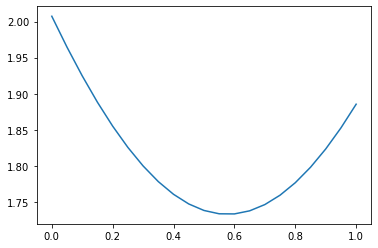

In [43]:
chart_val = []

w = np.linspace(0,1,21)

for i in w:
    pred3 = pred1*i + pred2*(1-i)
    rmse = np.sqrt(np.mean((pred3 - y_test.to_numpy())**2))
    chart_val.append([i, rmse])

chart_val_np = np.array(chart_val)
plt.plot(chart_val_np[:, 0], chart_val_np[:,1])

Dapat dilihat bahwa _weight_ terbaik (RMSE terkecil) adalah di antara `0,4` s.d. `0.6`.

---